In [15]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

In [16]:
Data=pd.read_csv('1000_y_data.csv')
X = Data[Data.columns[1:23]]
y = Data['rib16']
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [7]:
alpha = np.linspace(1e-07, 0.1, 200, endpoint=True)
solver=['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
# normalize=[True,False]


random_grid = {"alpha" :alpha,
#                "normalize":normalize,
               "solver":solver}

In [4]:
yt=np.log(y)
rf = Ridge()
reg = GridSearchCV(rf,param_grid = random_grid ,cv = cv, return_train_score=True,scoring="neg_root_mean_squared_error", verbose=2, n_jobs = -1)
reg.fit(X,y)
    

Fitting 10 folds for each of 1400 candidates, totalling 14000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 3668 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 5448 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7556 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9984 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 12740 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 14000 out of 14000 | elapsed:  3.0min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=False),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-07, 5.02612060e-04, 1.00512412e-03, 1.50763618e-03,
       2.01014824e-03, 2.51266030e-03, 3.01517236e-03, 3.51768442e-03,
       4.02019648e-03, 4.52270854e-03, 5.02522060e-03, 5.52773266e-03,
       6.03024472e-03, 6.53275678e-03, 7.03526884e-03, 7.5377...
       9.24623191e-02, 9.29648312e-02, 9.34673432e-02, 9.39698553e-02,
       9.44723673e-02, 9.49748794e-02, 9.54773915e-02, 9.59799035e-02,
       9.64824156e-02, 9.69849276e-02, 9.74874397e-02, 9.79899518e-02,
       9.84924638e-02, 9.89949759e-02, 9.94974879e-02, 1.00000000e-01]),
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [5]:
reg.best_estimator_

Ridge(alpha=0.026633239195979902, solver='sag')

In [17]:
modo=Ridge(alpha=0.026633239195979902, solver='sag')
mod = TransformedTargetRegressor(regressor=modo,func=np.log,inverse_func=np.exp)

In [18]:
cv = KFold(n_splits=10, random_state=1)

In [19]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=35)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')
kf=cv

## Learning Curve

<Figure size 576x396 with 0 Axes>

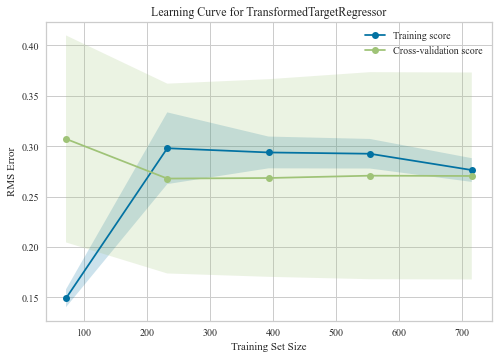

In [20]:
train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

## Unknown data test

In [21]:
X = X.to_numpy()
y = y.to_numpy()
y_Test=y_Test.to_numpy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 0.238957

Root Mean squared error: 0.466794

Root Mean squared error: 0.238551

Root Mean squared error: 0.176151

Root Mean squared error: 0.402920

Root Mean squared error: 0.273734

Root Mean squared error: 0.368113

Root Mean squared error: 0.148401

Root Mean squared error: 0.231897

Root Mean squared error: 0.158103

error COV--->0    2.127195
dtype: float64  error mean --->0    0.097594
Name: mean, dtype: float64  error std --->0    0.207601
Name: std, dtype: float64


# train score

In [22]:
ytr=HBM_Train.predict(X)
err=np.zeros(len(ytr))
for u in range (0,len(ytr)):
    err[u]=np.sqrt((y[u]-ytr[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    2.112728
dtype: float64  error mean --->0    0.118101
Name: mean, dtype: float64  error std --->0    0.249516
Name: std, dtype: float64


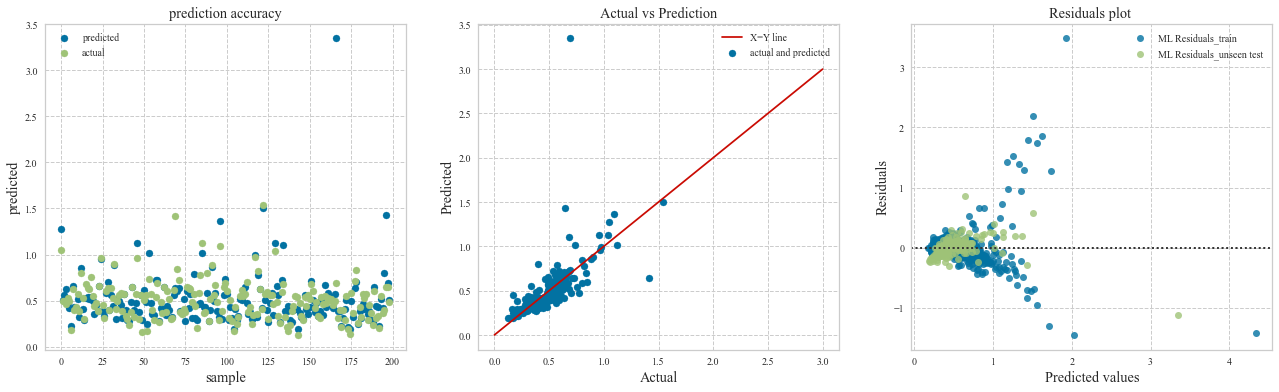

In [23]:
plt.figure(figsize=(22, 6))
csfont = {'fontname':'Times New Roman'}
plt.subplot(1,3,1)
plt.scatter(np.arange(0,len(ytestunk)),ytestunk,label='predicted')
plt.scatter(np.arange(0,len(y_Test)),y_Test,label='actual')
plt.grid( linestyle='--')
plt.title('prediction accuracy', fontsize='large',**csfont)
plt.xlabel('sample', fontsize='large',**csfont)
plt.ylabel('predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,2)
plt.scatter(y_Test,ytestunk,label='actual and predicted')
plt.plot([0,3],[0,3],color='r',label='X=Y line')
plt.grid( linestyle='--')
plt.title('Actual vs Prediction', fontsize='large',**csfont)
plt.xlabel('Actual', fontsize='large',**csfont)
plt.ylabel('Predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,3)
a=sns.residplot(y=abs(y), x=abs(ytr),label='ML Residuals_train')
r=sns.residplot(y=abs(y_Test), x=abs(ytestunk),label='ML Residuals_unseen test')
plt.grid( linestyle='--')
plt.title('Residuals plot ', fontsize='large',**csfont)
plt.xlabel('Predicted values', fontsize='large',**csfont)
plt.ylabel('Residuals', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.show()